# Stress implementation

In [1]:
import os
import tifffile as tf

import matplotlib.pyplot as plt
import napari

import pandas as pd
import numpy as np

from stress import stress, utils, tracing, surface

%matplotlib notebook

Load data

### Config

In [2]:
fluorescence = 'interior'  # type of fluorescence
n_samples = 2**8  # number of points on initial estimate
trace_fit_method = 'quick_edge'
patch_radius = 2  # radius within which a point is counted as neighbour of another point
n_refinements = 2  # number of refinement steps for surface resampling
surface_sampling_density = 1  # designated density of points on the drop surface

### Processing

In [3]:
root = r'D:\Documents\Promotion\Projects\2021_STRESS_translation'
f_image = os.path.join(root, 'data', 'ExampleTifSequence-InteriorLabel-vsx_2.076um-vsz_3.998um-TimeInterval_3.00min-21timesteps.tif')    

series = tf.imread(f_image)

Pick one timepoint and visualize

<IPython.core.display.Javascript object>


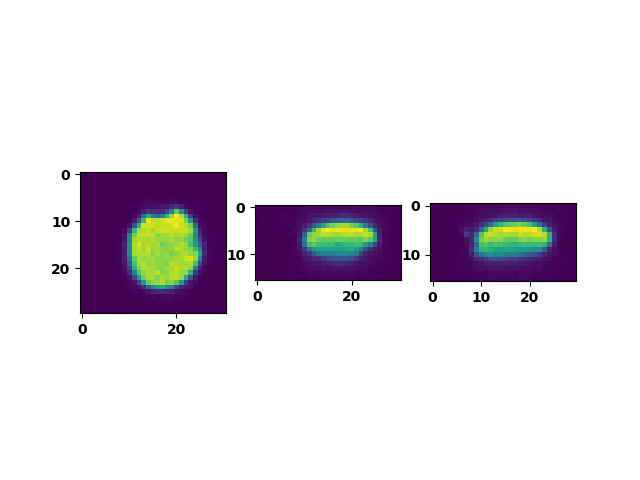

In [4]:
image = series[0]

fig, axes = plt.subplots(ncols=3)
axes[0].imshow(image[image.shape[0]//2])
axes[1].imshow(image[:, image.shape[1]//2, :])
axes[2].imshow(image[:, :, image.shape[2]//2])

### Preprocessing
Do some preprocessing:
- Resampling

<IPython.core.display.Javascript object>


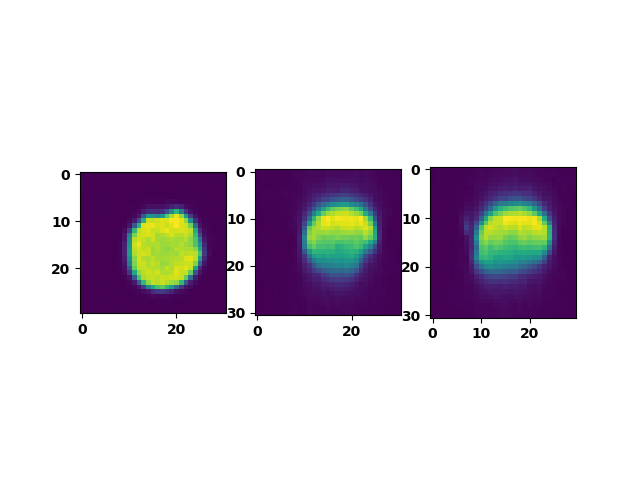

In [5]:
image = stress.preprocessing(image, vsx=2.076, vsy=2.076, vsz=3.998)

fig, axes = plt.subplots(ncols=3)
axes[0].imshow(image[15])
axes[1].imshow(image[:, 15, :])
axes[2].imshow(image[:, :, 15])

###  Initial ellipse fit
To get an initial estimate on the shape and surface of the oil drop, fit an ellipse to the dropplet:

In [6]:
_points = stress.fit_ellipse(image, fluorescence=fluorescence, n_samples=n_samples)

To keep track of the data, create a pandas dataframe for our data and store the detected points in the dataframe:

In [7]:
_points = np.asarray(_points).transpose()  # convert to 3xN array
points = pd.DataFrame(columns=['Z', 'Y', 'X'])
points['Z'] = _points[0, :]
points['Y'] = _points[1]
points['X'] = _points[2]
center = np.asarray([points.Z.mean(), points.Y.mean(), points.X.mean()])

Visualize in napari

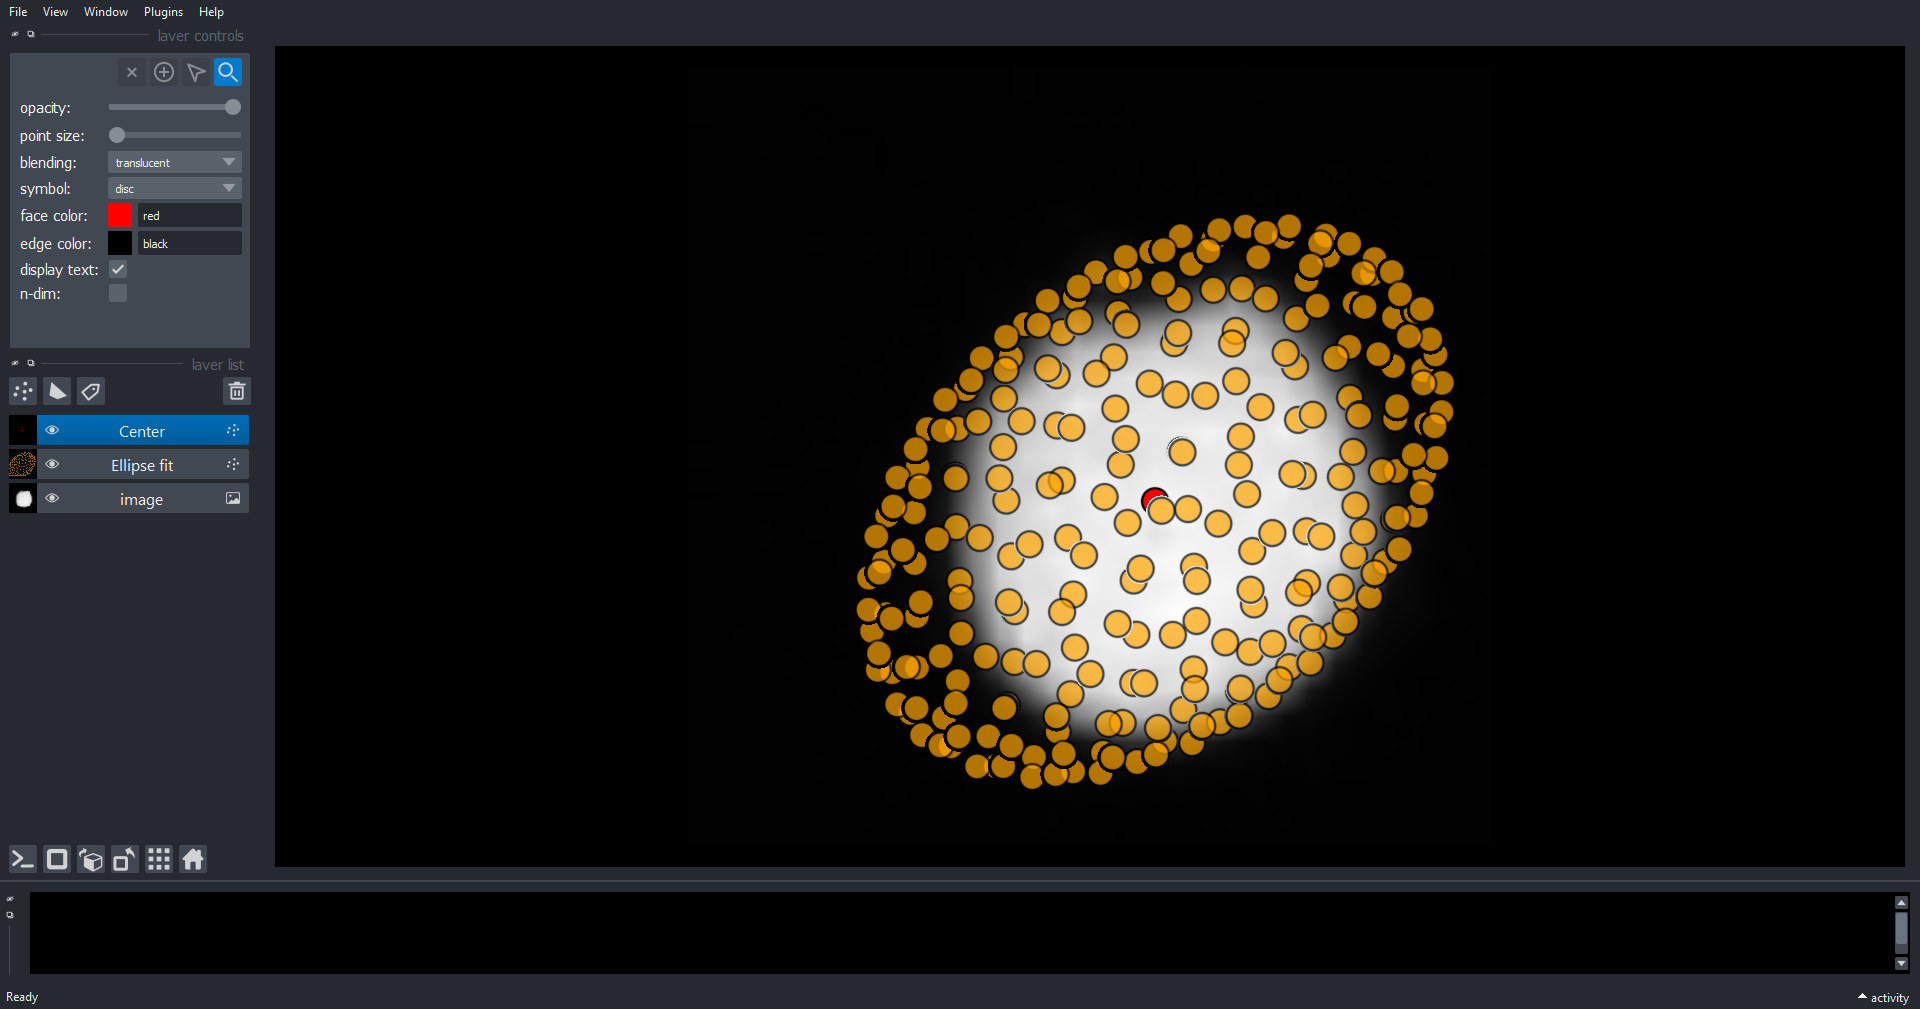

In [8]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image, colormap='gray')
ellipse_layer = viewer.add_points(utils.df2ZYX(points), size=1, face_color ='orange', edge_width=0.1, opacity=0.7, name='Ellipse fit')
viewer.add_points(center, size=1, face_color ='red', edge_width=0.1, opacity=1.0, name='Center')
napari.utils.nbscreenshot(viewer, canvas_only=False)

### Ray-tracing
Shoot rays from center towards all currently known surface points. Image intensity is measured along the way.
If fluorescence = 'interior', the surface is considered to be the location where intensity drops to 0.5 x maxIntensity.
If fluorescence = 'edge', the surface is considered to be the location of maximal intesity along the ray.

In [9]:
new_points, errors, fitparams = tracing.get_traces(image, start_pts=center, target_pts=utils.df2ZYX(points),
                                                    detection=trace_fit_method, fluorescence=fluorescence)
points['Z'] = new_points[:, 0]
points['Y'] = new_points[:, 1]
points['X'] = new_points[:, 2]
points['errors'] = errors
points['fitparams'] = fitparams

Shooting rays: 100%|████████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 142.29it/s]


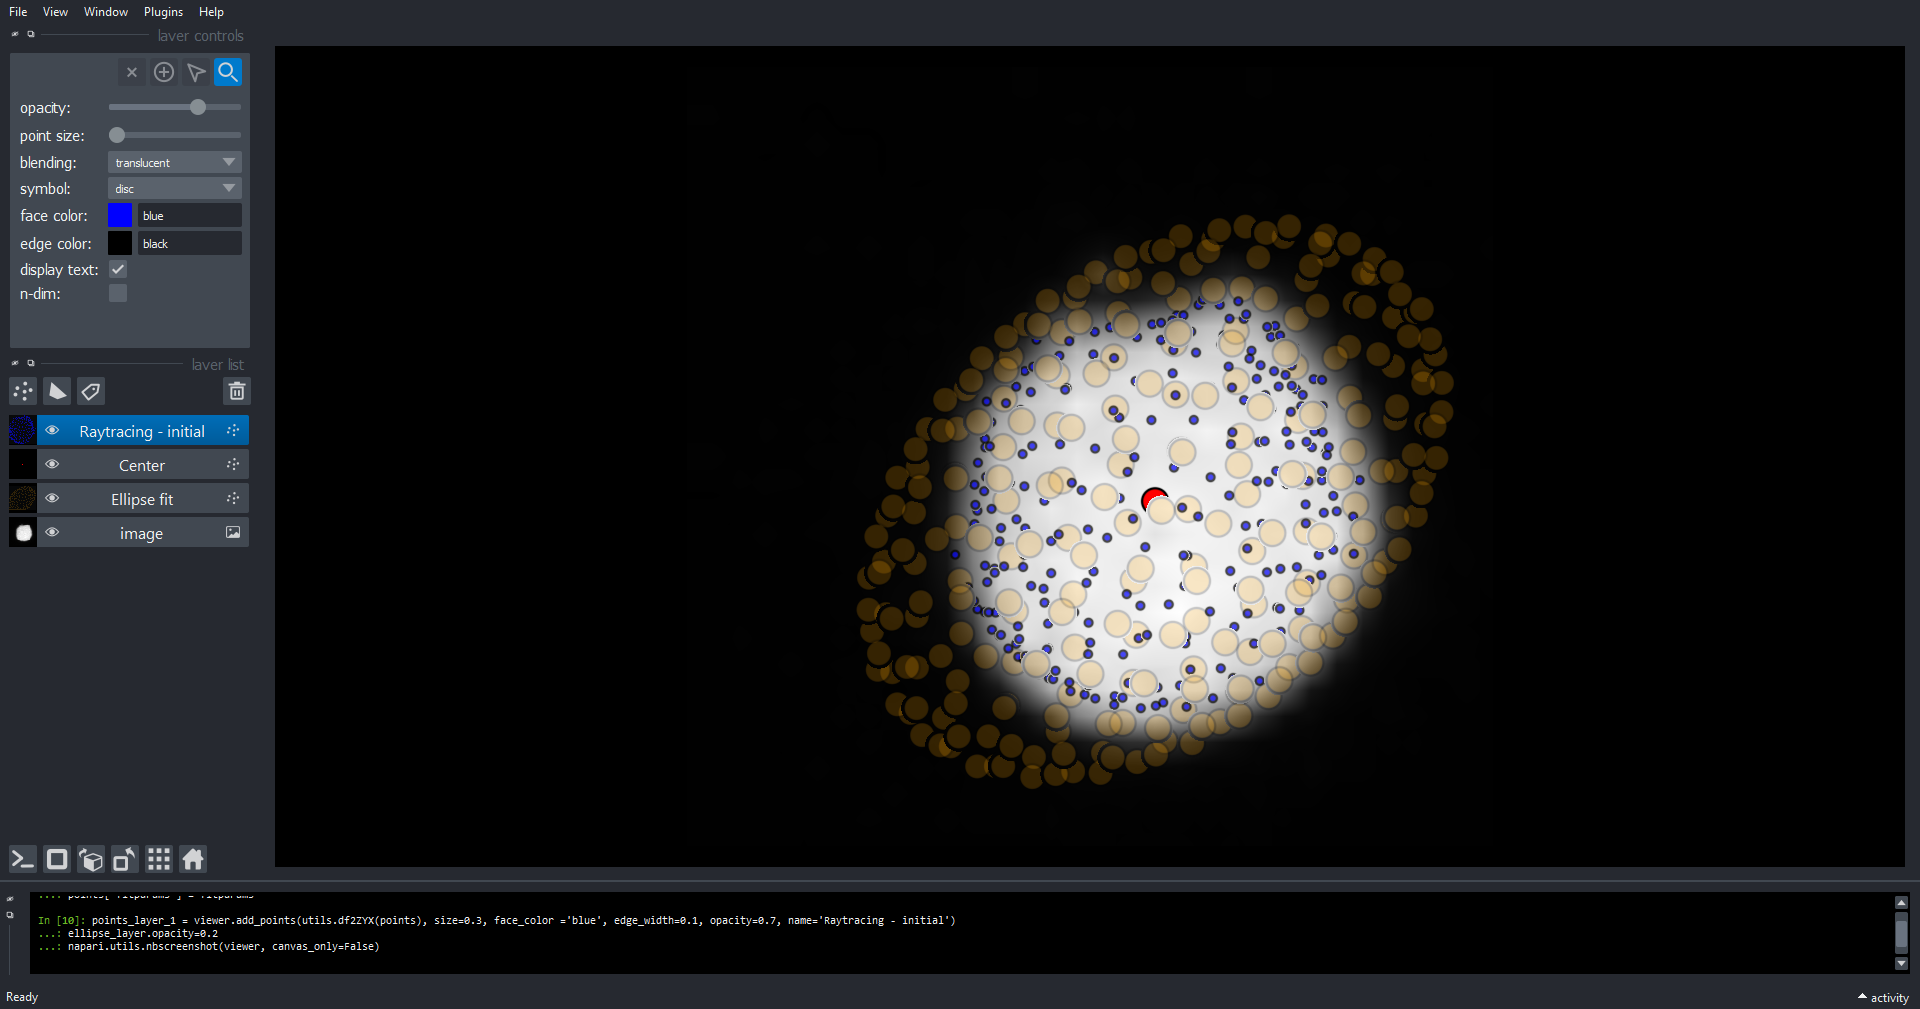

In [10]:
points_layer_1 = viewer.add_points(utils.df2ZYX(points), size=0.3, face_color ='blue', edge_width=0.1, opacity=0.7, name='Raytracing - initial')
ellipse_layer.opacity=0.2
napari.utils.nbscreenshot(viewer, canvas_only=False)

### Surface filtering

Next, we want to reject "bad" points from the list of identified points on the surface. For this, we first identify the neighbours of each point and add the index and number of neighbours to the dataframe. The ```neighbours``` attribute contains the row index of the neighbouring point and ```n_neighbours``` contains the number of each point's neighbours for convenience.

In [11]:
neighbours, n_neighbours = surface.get_neighbours(utils.df2ZYX(points), patch_radius=patch_radius)
points['neighbours'] = neighbours
points['n_neighbours'] = n_neighbours
points

Z          Y          X  errors  fitparams  \
0    13.009809  11.362977  22.522064     0.0        0.0   
1    13.305129  12.131225  23.181890     0.0        0.0   
2    13.992515  10.306900  22.863135     0.0        0.0   
3    12.186995  11.779497  22.761192     0.0        0.0   
4    14.437898  11.554684  23.927178     0.0        0.0   
..         ...        ...        ...     ...        ...   
251  13.708365  20.374746  10.670638     0.0        0.0   
252  12.746795  22.205836  12.241597     0.0        0.0   
253  14.723573  21.391441  11.530163     0.0        0.0   
254  13.010654  21.163882  11.228658     0.0        0.0   
255  13.713121  21.887222  11.860551     0.0        0.0   

                                   neighbours  n_neighbours  
0                   [5, 13, 8, 0, 3, 1, 6, 2]             8  
1               [0, 3, 1, 11, 6, 14, 2, 4, 9]             9  
2                  [5, 0, 1, 10, 15, 2, 7, 4]             8  
3                     [8, 0, 3, 16, 1, 11, 6]             7  
4                     [1, 2, 7, 12, 4, 9, 17]             7  
..                                        ...           ...  
251  [238, 246, 254, 243, 251, 248, 253, 255]             8  
252  [254, 249, 244, 252, 247, 239, 255, 250]             8  
253  [254, 251, 248, 240, 253, 245, 255, 250]             8  
254  [246, 241, 254, 249, 252, 251, 253, 255]             8  
255  [254, 249, 252, 247, 251, 253, 255, 250]             8  

[256 rows x 7 columns]

We now use the ```filter_dataframe()``` function which calculates quantiles and interquartile distances for every point property and rejects points classified as outliers from the dataframe. In this case, we want to remove points with hardly any neighbours (e.g. that are somehow far away from the surface) or an excessive number of neighbours (for instance due to local edges in the surface)

In [12]:
points = utils.filter_dataframe(points, columns=['n_neighbours'], criteria=['within'], inplace=True, verbose=True)

Removed 0 points based on n_neighbours-criterion


### Surface resampling
It is necessary to resample the points on the surface as the initial fit procedure may yield inaccurate results. For demonstration: 

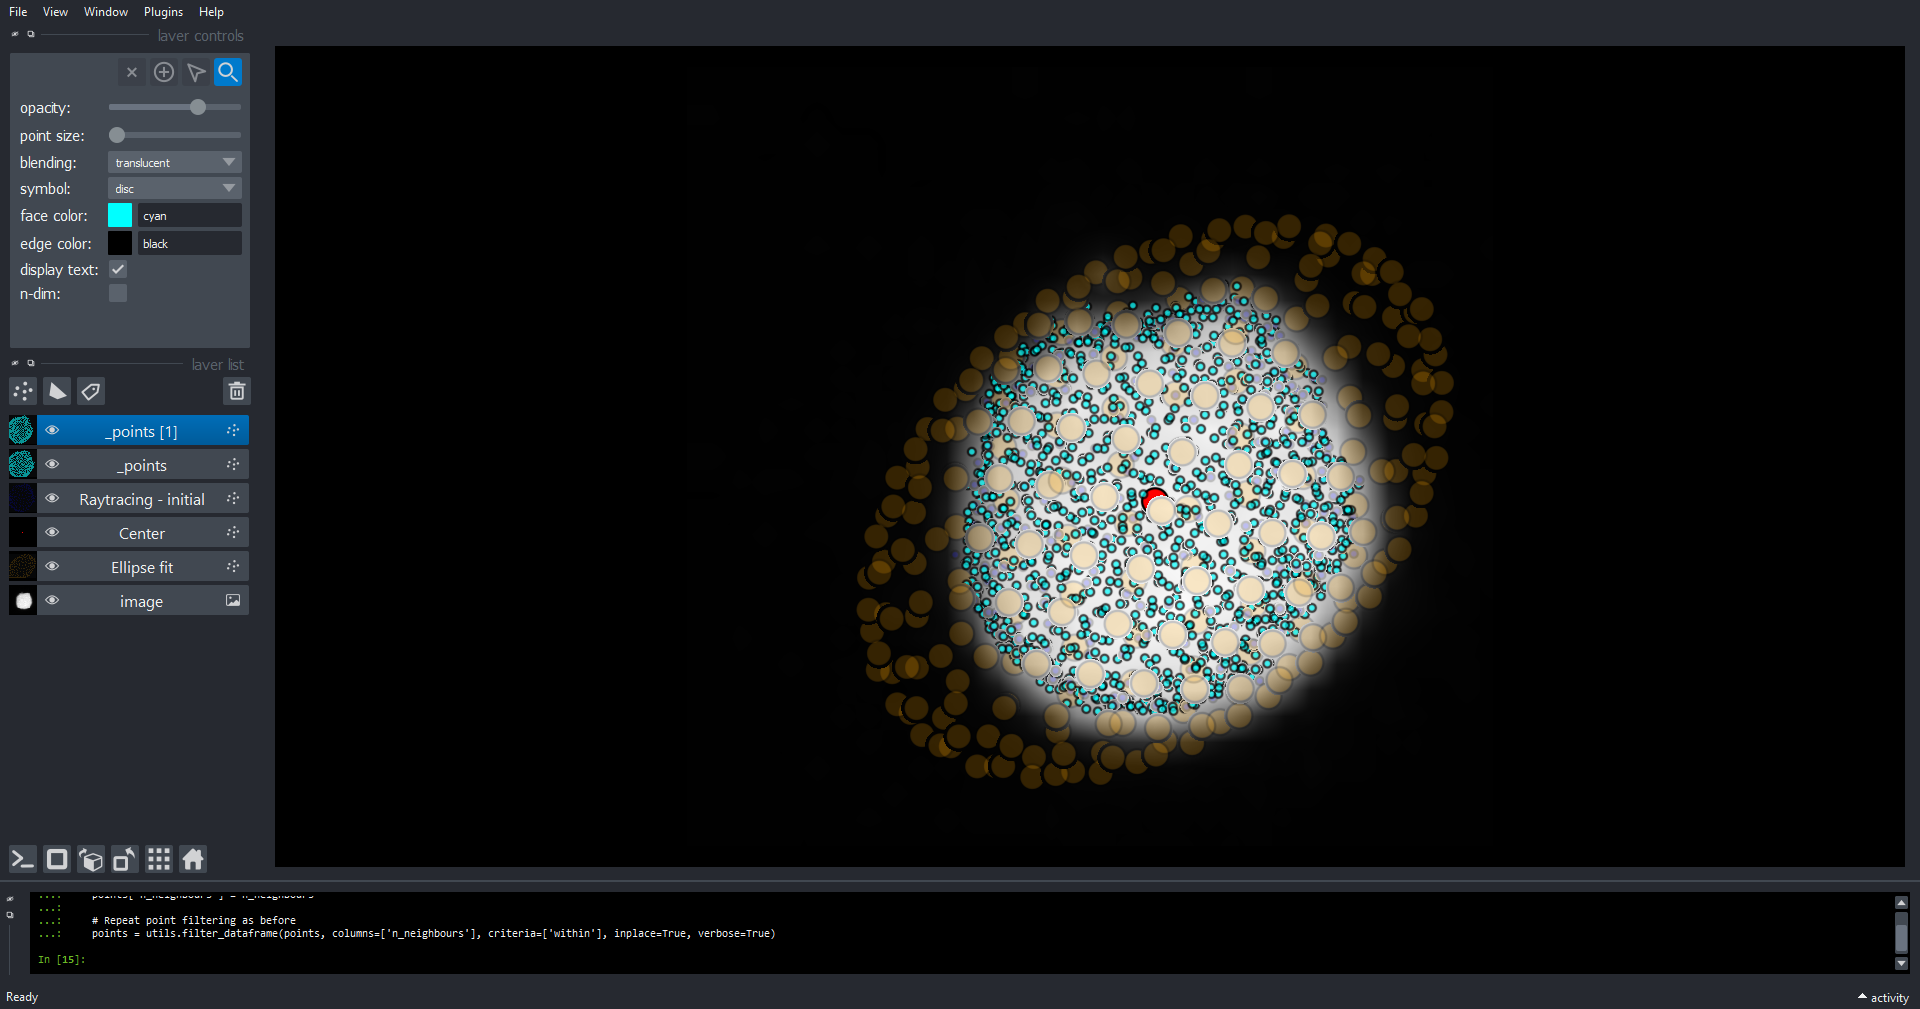

In [15]:
_points = surface.resample_points(utils.df2ZYX(points), surface_sampling_density=surface_sampling_density)
points_layer_1.opacity = 0.2
points_layer_2 = viewer.add_points(_points, size=0.3, face_color ='cyan', edge_width=0.1, opacity=0.7, name='Points_resampled')
napari.utils.nbscreenshot(viewer, canvas_only=False)

This procedure is now repeated for a number of ```n_refinements``` (default = 2). During each iteration, the following steps are executed:
- Surface is resampled to predefined density
- Local normals are calculated
- Raytracing is repeated along the calculated normal
- Coordinates are filtered

In [14]:
for i in range(n_refinements):
    print(f'Iteration #{i+1}:')

    # resample points on surface to desired density
    _points = surface.resample_points(utils.df2ZYX(points), surface_sampling_density=surface_sampling_density)

    # Calculate local normals
    normals = surface.get_local_normals(_points)

    # Calculate starting points for advanced tracing and run tracing
    start_pts = _points - 2*normals
    _points, errors, fitparams = tracing.get_traces(image, start_pts=start_pts, target_pts=_points,
                                                    detection=trace_fit_method, fluorescence=fluorescence)

    # Find neighbours
    neighbours, n_neighbours = surface.get_neighbours(_points, patch_radius=patch_radius)

    # Overwrite dataframe with data from new points
    points = pd.DataFrame(columns=points.columns)
    points['Z'] = _points[:, 0]
    points['Y'] = _points[:, 1]
    points['X'] = _points[:, 2]
    points['errors'] = errors
    points['fitparams'] = fitparams
    points['neighbours'] = neighbours
    points['n_neighbours'] = n_neighbours

    # Repeat point filtering as before
    points = utils.filter_dataframe(points, columns=['n_neighbours'], criteria=['within'], inplace=True, verbose=True)

Iteration #1:


Finding normals: 654it [00:00, 760.77it/s]
Shooting rays: 100%|████████████████████████████████████████████████████████████████| 654/654 [00:04<00:00, 151.48it/s]


Removed 27 points based on n_neighbours-criterion
Iteration #2:


Finding normals: 708it [00:00, 725.04it/s]
Shooting rays: 100%|████████████████████████████████████████████████████████████████| 708/708 [00:04<00:00, 151.22it/s]

Removed 2 points based on n_neighbours-criterion


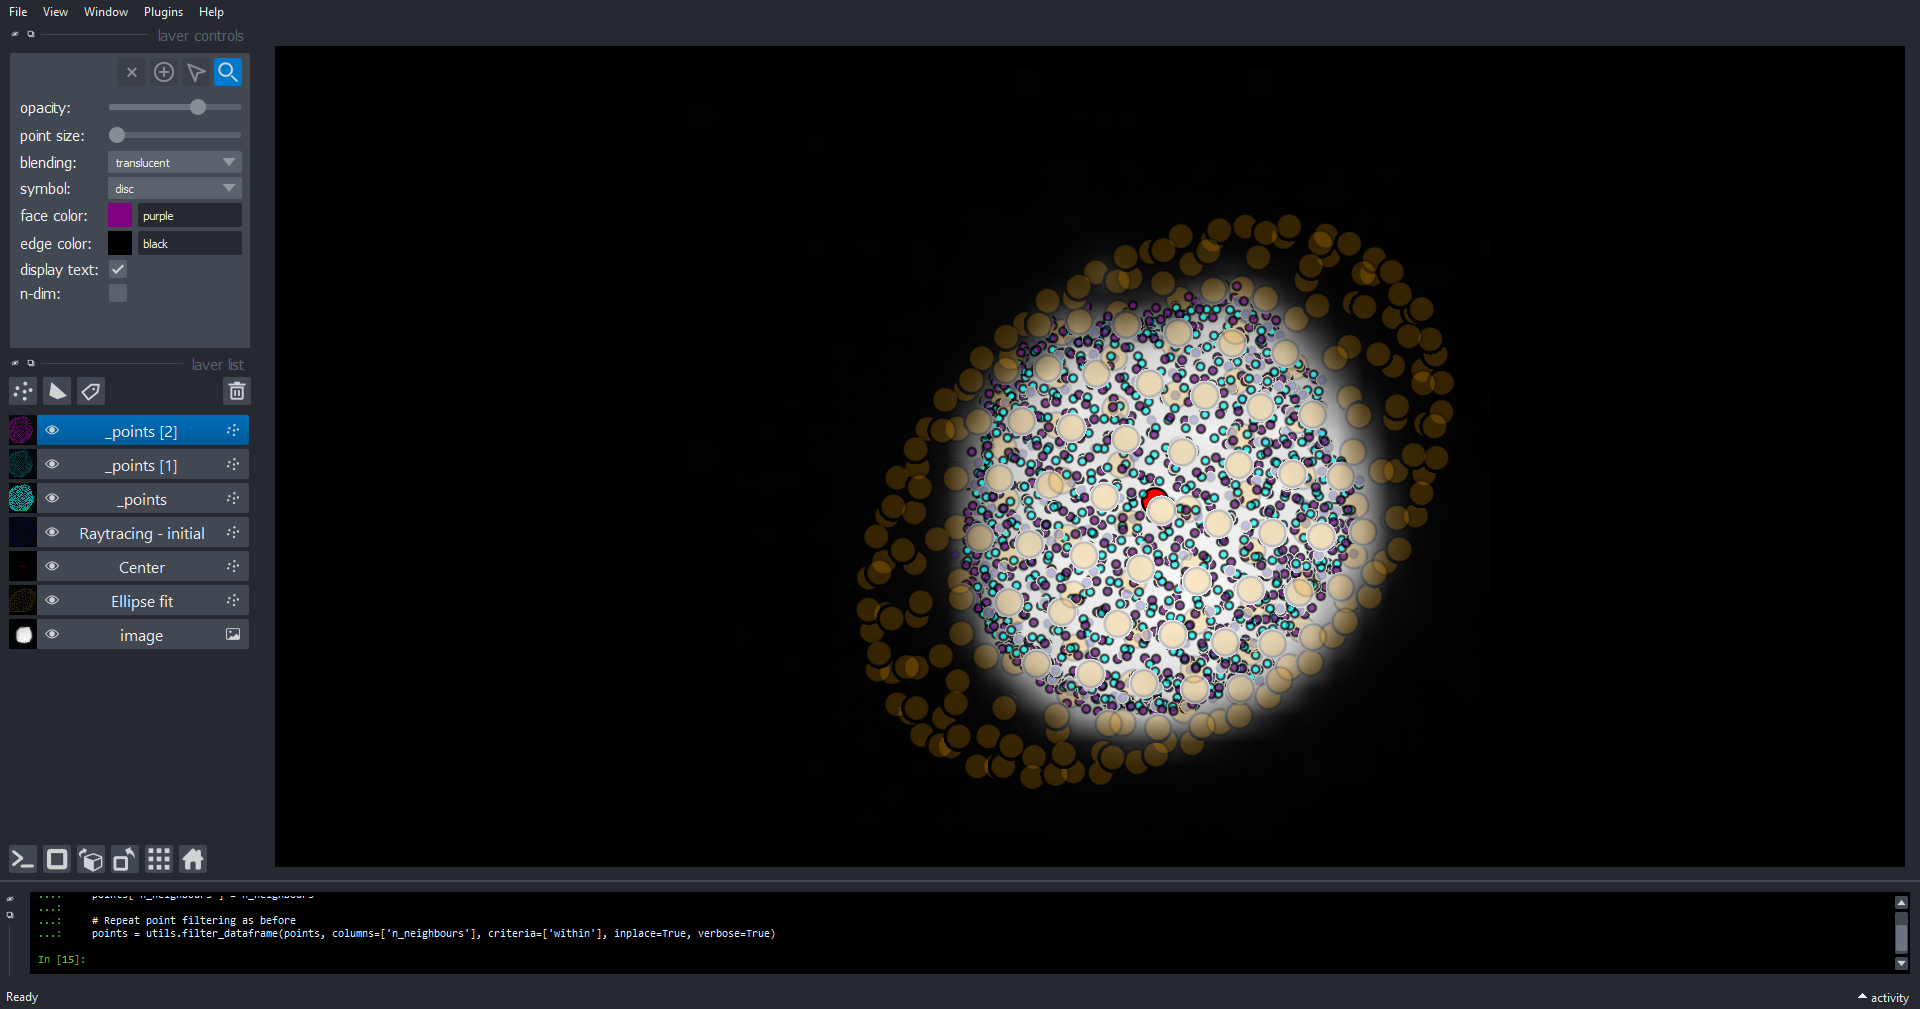

In [16]:
points_layer_2.opacity = 0.2
points_layer_3 = viewer.add_points(_points, size=0.3, face_color ='purple', edge_width=0.1, opacity=0.7, name='Points_refined')
napari.utils.nbscreenshot(viewer, canvas_only=False)